Found Synapse note file: C:\Users\lf936249\Documents\Python Scripts\VTA4-190125-100559\Notes.txt
read from t=0s to t=785.44s
Loaded block at: C:\Users\lf936249\Documents\Python Scripts\VTA4-190125-100559
Streams: ['_480G', '_405G', 'Fi1r']
Epocs:   ['Ler_', 'Note']


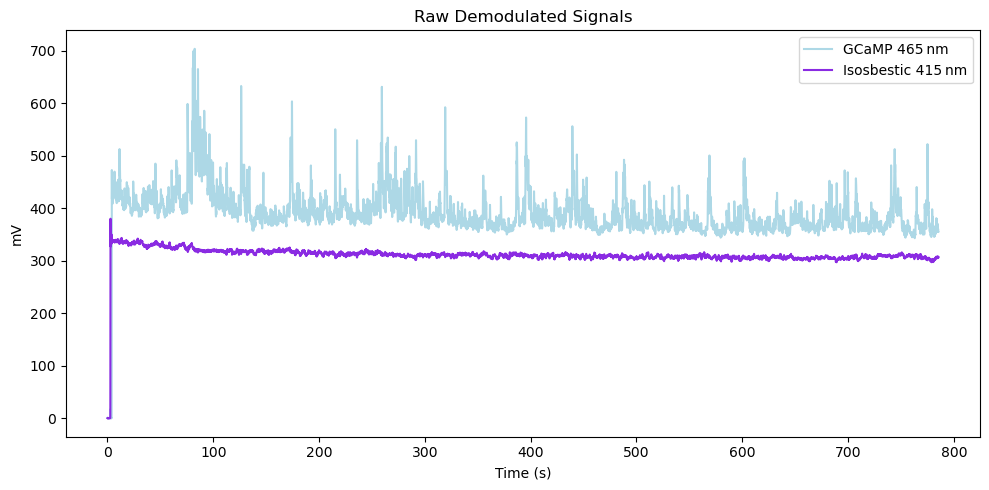


Lever IPI summary:
 Count: 768  Min: 0.030s  Mean: 0.791s  Max: 54.271s

Lick IPI summary:
 Count: 768  Min: 0.030s  Mean: 0.791s  Max: 54.271s


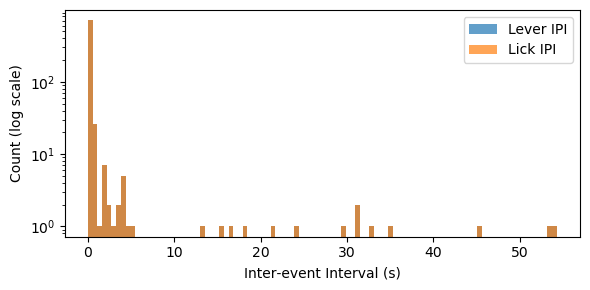

ARTIFACT_CUTOFF=71.735s; DOWNSAMPLE_FACTOR=10; BOUT_TIME_THRESH=1.5


C:\Users\lf936249\AppData\Local\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 1172725.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\lf936249\AppData\Local\anaconda3\Lib\site-packages\scipy\stats\_continuous_distns.py:6545: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)



Lever best fit: lognorm, SW p=0.000, skew=1.57, kurtosis=6.29
 AIC ranking: [('lognorm', 8572745.91441787), ('norm', 9074400.906980814), ('expon', 9283061.099949783), ('gamma', 23656511.81231774)]


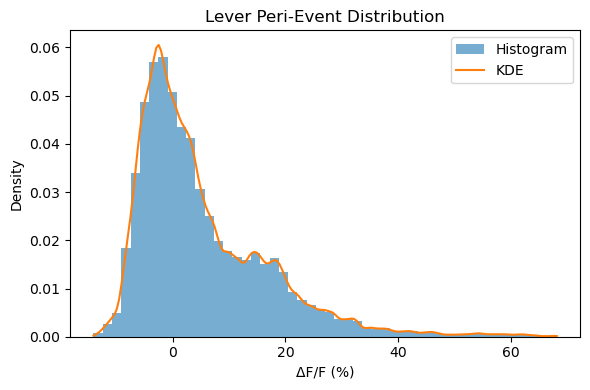

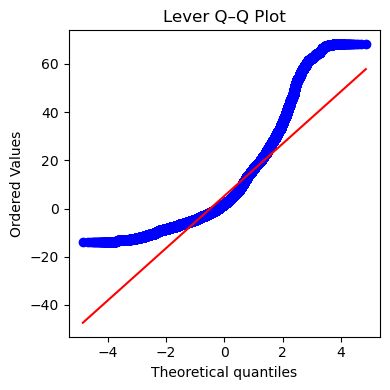


Lick best fit: lognorm, SW p=0.000, skew=1.57, kurtosis=6.29
 AIC ranking: [('lognorm', 8572745.91441787), ('norm', 9074400.906980814), ('expon', 9283061.099949783), ('gamma', 23656511.81231774)]


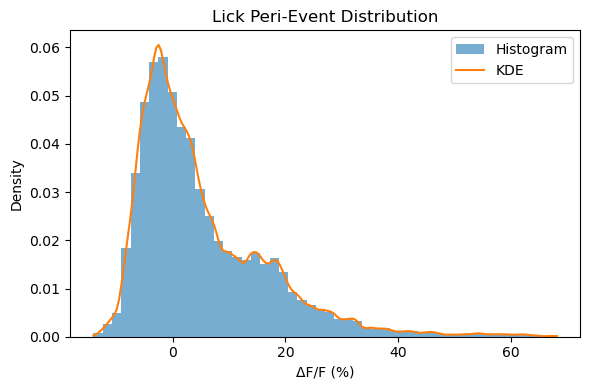

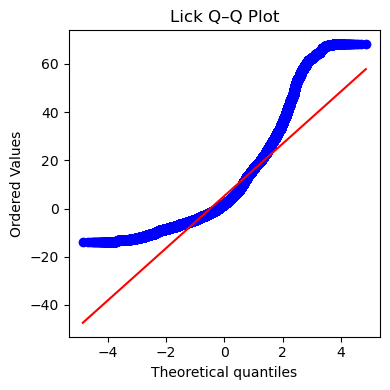

Dropping 362 lever trials (time‐point outliers) out of 769
Dropping 0 lever trials (peak outliers) out of 769
Dropping 362 lick trials (time‐point outliers) out of 769
Dropping 0 lick trials (peak outliers) out of 769
Lever: optimal Δ = 2.790s, deflection‐point Δ = 2.790s


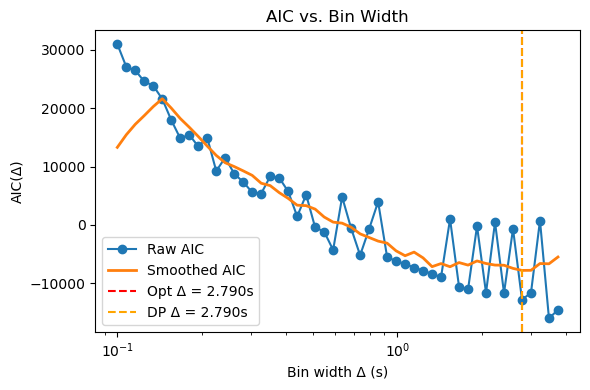

Lick: optimal Δ = 2.790s, deflection‐point Δ = 2.790s


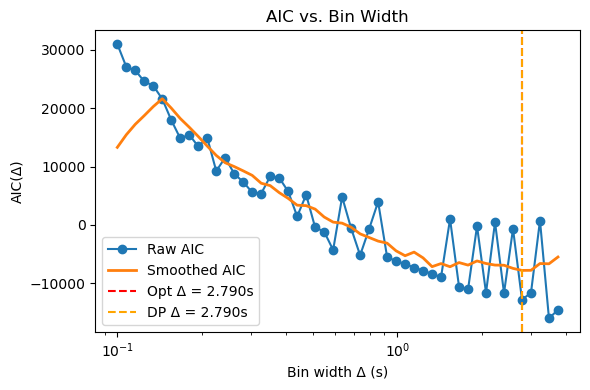

Denoised 407 lever trials with MISE‐optimal filter.
Denoised 407 lick trials with MISE‐optimal filter.


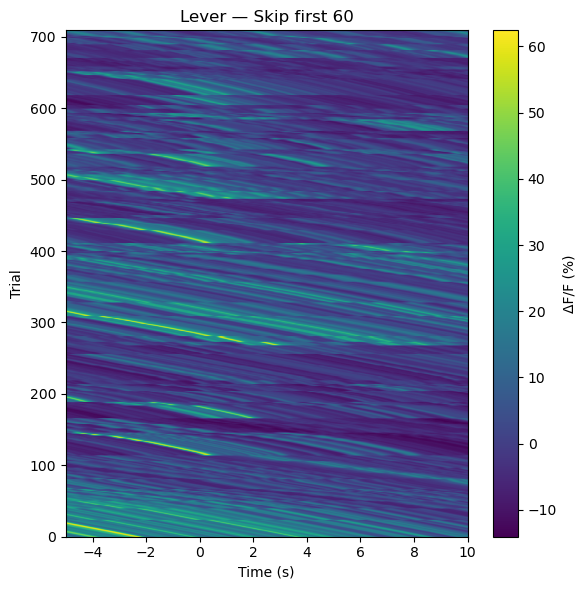

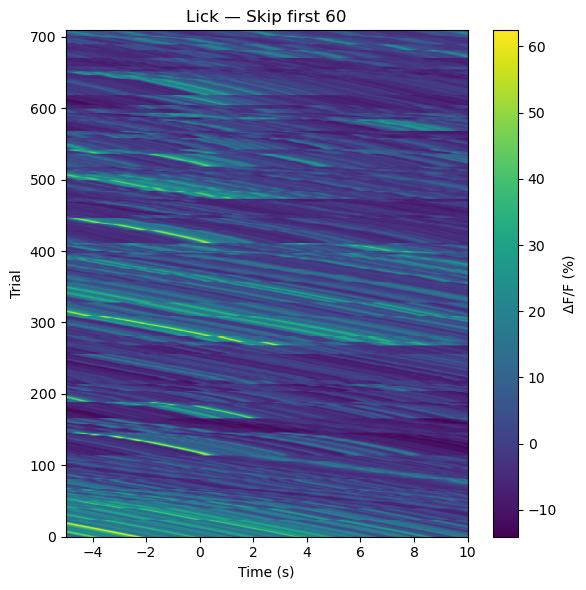

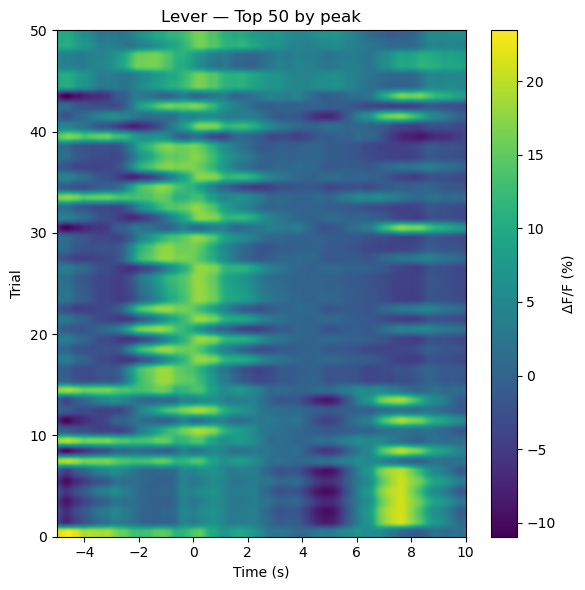

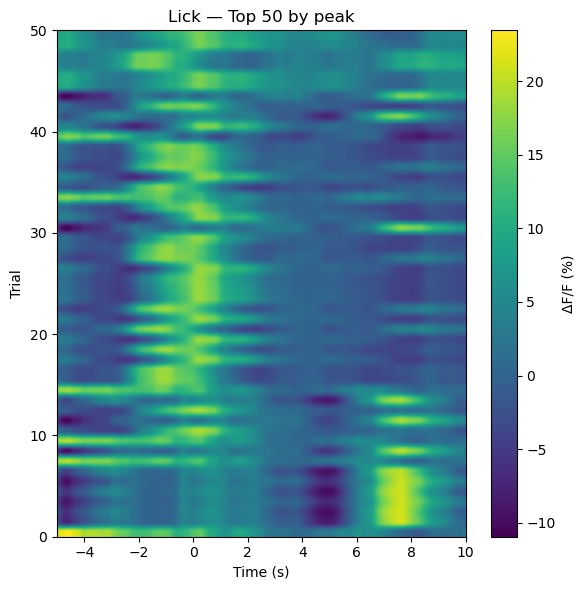

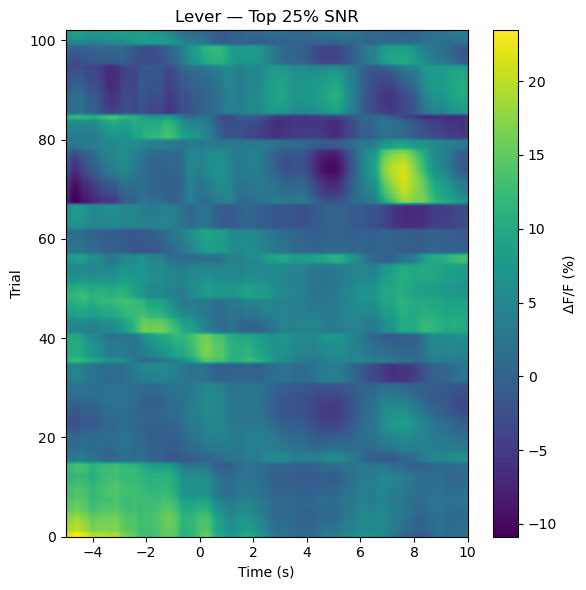

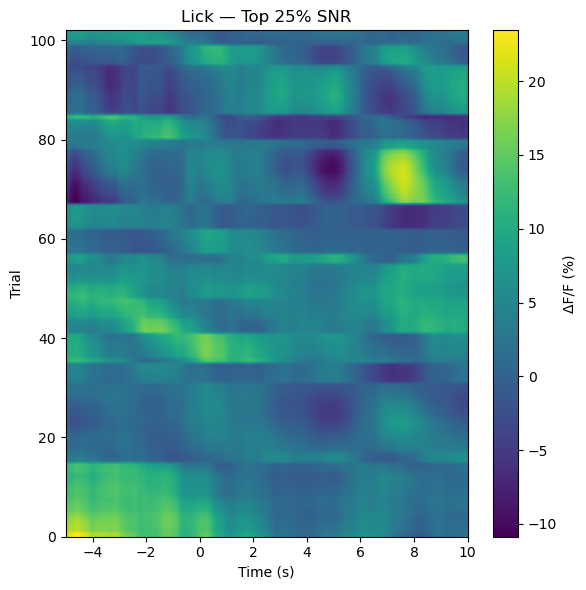

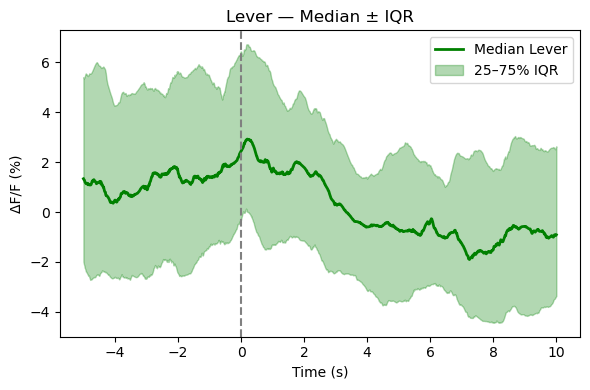

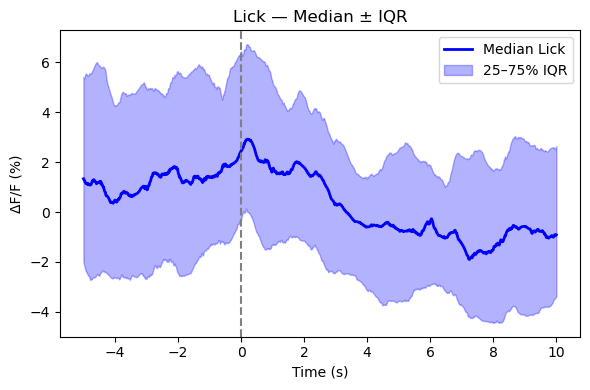


Detected 429 peaks: [ 80.632  80.779  81.114  81.261  81.408  82.264  82.411  82.559  82.706
  83.856  84.004  85.508  85.655  91.73   91.878  92.025  92.173  92.32
  92.468  92.615  92.763  92.91   93.058  93.205  93.352  93.5    93.647
  93.795  93.942  94.09   94.237  94.385  94.532  95.142  95.289  95.436
  95.584  95.731  95.879  96.144  96.292  96.439  96.587  97.383  97.53
  97.678  97.825  97.973  98.12   98.268  98.415  98.563  99.624  99.772
  99.919 100.725 103.33  103.478 103.625 104.795 104.942 106.614 106.761
 106.909 107.97  108.688 112.266 112.414 112.561 112.836 131.72  131.868
 132.015 132.163 132.802 132.949 133.097 133.864 134.011 134.158 134.306
 147.135 147.282 147.429 173.008 173.156 173.303 174.394 174.542 192.02
 192.168 192.315 192.463 192.993 215.2   215.348 221.718 221.865 222.013
 222.16  222.308 222.455 222.603 222.75  222.897 223.045 223.192 223.34
 223.487 223.635 223.782 223.93  224.077 224.225 224.372 224.519 224.667
 224.814 224.962 225.109 225.257 2

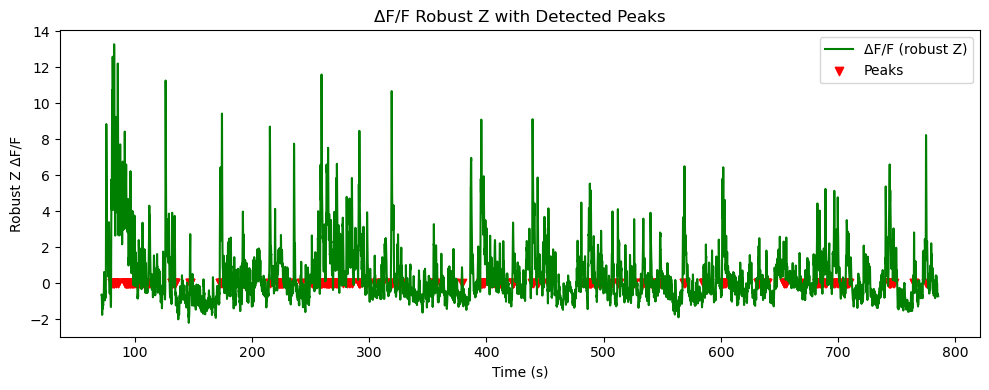

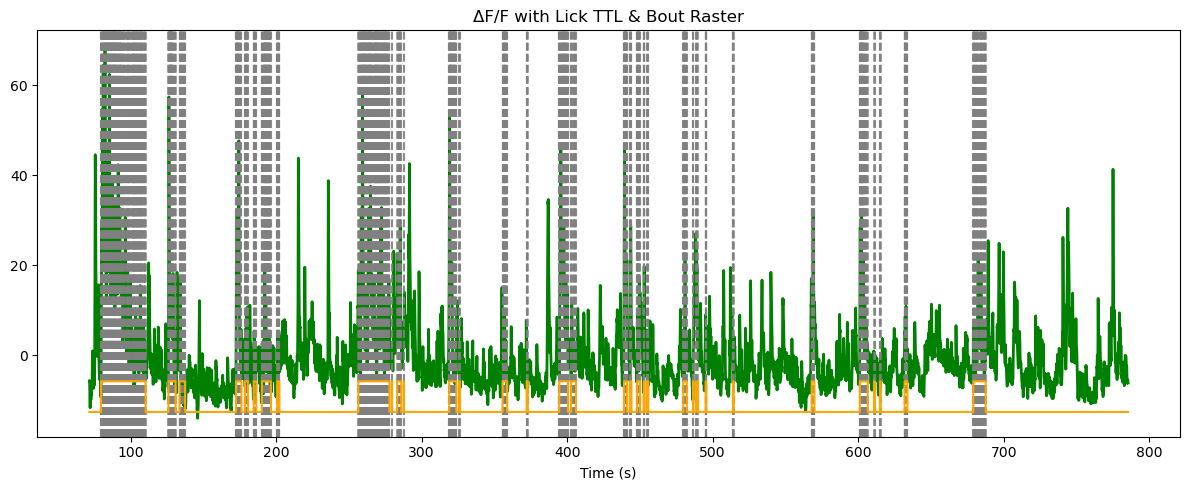

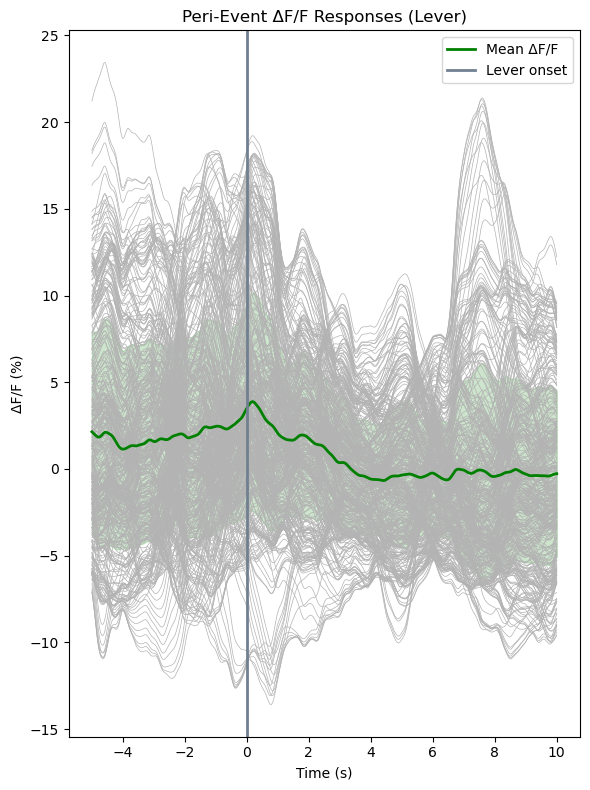

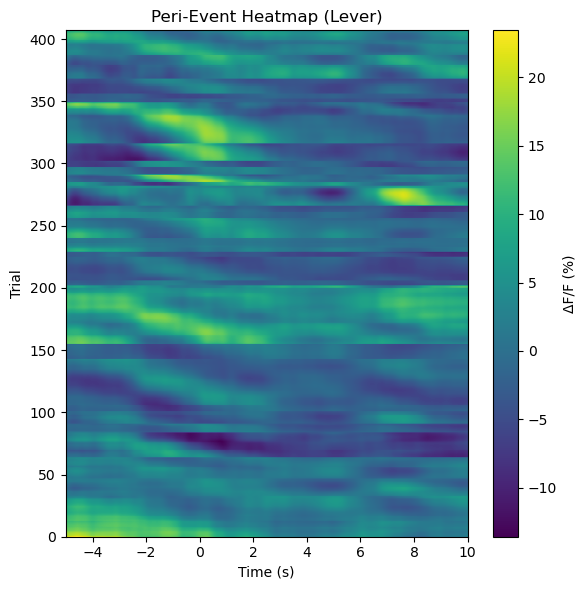

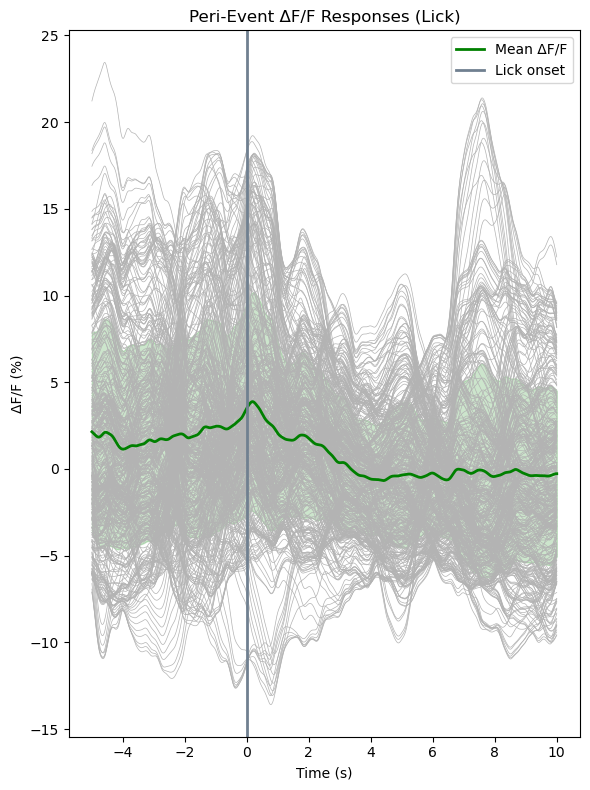

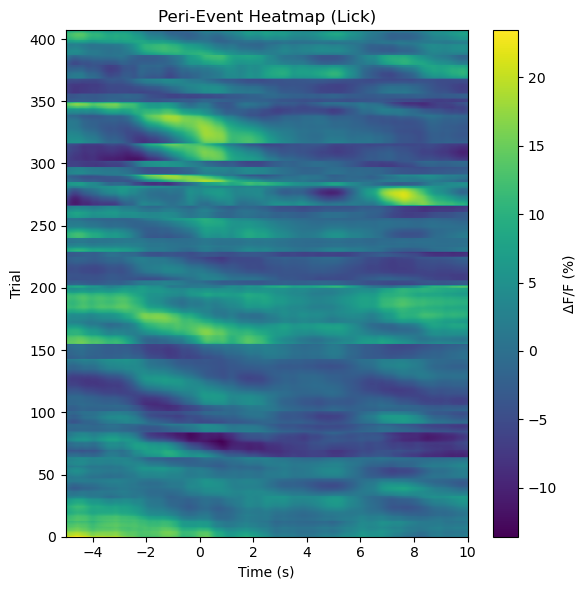

Saved Lever snips CSV to C:\Users\lf936249\Documents\Python Scripts\VTA4-190125-100559\analysis_outputs\peri_event_lever_snips.csv
Saved Lick snips CSV to   C:\Users\lf936249\Documents\Python Scripts\VTA4-190125-100559\analysis_outputs\peri_event_lick_snips.csv


In [27]:
# %% 
# 1. Imports & Definitions
# -------------------------
import os                                  # For file‐path manipulations, if needed later
import numpy as np                         # Core numerical library: arrays, math functions
import pandas as pd                        # DataFrame: tables for summarizing metrics (e.g., TTL counts)
import scipy.stats as st                   # Statistical tests and distribution fitting (Shapiro‐Wilk, AIC, etc.)
import matplotlib.pyplot as plt            # Plotting (line plots, histograms, heatmaps)
import tdt                                 # TDT block reader: loads continuous streams & epocs from TDT data blocks
from scipy.signal import filtfilt          # Zero‐phase filtering (no phase shift) for smoothing signals
from scipy.stats import zscore, median_abs_deviation  
               # zscore: standard normalization; median_abs_deviation: robust normalization metric (MAD)
from scipy.ndimage import gaussian_filter1d  
               # Gaussian smoothing: models sensor kinetics (e.g., GCaMP rise time ~100–150 ms)
from scipy.linalg import eigh, svd         # Linear algebra: eigen‐ and singular‐value decompositions for MISE denoising

# Path to your TDT block folder
BLOCKPATH = r"C:\Users\lf936249\Documents\Python Scripts\VTA4-190125-100559"

# Stream & TTL store names (do not change)
GCAMP = '_480G'   # 465 nm GCaMP channel
ISOS  = '_405G'   # 415 nm isosbestic channel
LEVER = 'Ler_'    # lever‐press epoc store
LICK  = 'Ler_'    # lick TTL epoc store


# -----------------------------------------------------------------------------
# 1.1 AIC‐Based Binning Functions
# -----------------------------------------------------------------------------
def optimal_bin_width(trials, pre, post, fs, 
                      n_deltas=50, delta_min=None, delta_max=None, 
                      smooth_win=10):
    """
    Compute AIC-based optimal and deflection‐point bin widths for peri‐event histograms.
    ...
    (full docstring omitted for brevity)
    """
    if delta_min is None:
        delta_min = 2.0 / fs
    if delta_max is None:
        delta_max = (pre + post) / 4.0

    deltas = np.logspace(np.log10(delta_min), np.log10(delta_max), n_deltas)
    dt = 1.0 / fs
    edges_fine = np.arange(-pre, post + dt/2, dt)
    counts_fine = np.vstack([np.histogram(tr, bins=edges_fine)[0] for tr in trials])
    lambda1 = counts_fine.mean(axis=0) / dt
    centers_fine = edges_fine[:-1] + dt/2
    T = len(lambda1)

    aic_raw = []
    for Δ in deltas:
        edges = np.arange(-pre, post + Δ/2, Δ)
        counts = np.vstack([np.histogram(tr, bins=edges)[0] for tr in trials])
        lam = counts.mean(axis=0) / Δ
        centers = edges[:-1] + Δ/2
        lam1_i = np.interp(centers, centers_fine, lambda1)
        SSE = np.sum((lam - lam1_i)**2)
        P = T / Δ
        aic_raw.append(T * np.log(SSE / T) + 2.0 * P)
    aic_raw = np.array(aic_raw)

    kernel = np.ones(smooth_win) / smooth_win
    aic_smooth = np.convolve(aic_raw, kernel, mode='same')

    idx_opt = np.argmin(aic_smooth)
    delta_opt = deltas[idx_opt]

    thresh = aic_smooth.min() * 1.05
    cands = np.where(aic_smooth <= thresh)[0]
    idx_dp = cands[0] if len(cands) else idx_opt
    delta_dp = deltas[idx_dp]

    return delta_opt, delta_dp, deltas, aic_raw, aic_smooth


def plot_aic(deltas, aic_raw, aic_smooth, delta_opt, delta_dp):
    """
    Plot raw and smoothed AIC vs. bin width Δ on a log scale.
    """
    plt.figure(figsize=(6,4))
    plt.plot(deltas, aic_raw, 'o-', label='Raw AIC')
    plt.plot(deltas, aic_smooth, '-', lw=2, label='Smoothed AIC')
    plt.axvline(delta_opt, color='red', ls='--', label=f'Opt Δ = {delta_opt:.3f}s')
    plt.axvline(delta_dp,  color='orange', ls='--', label=f'DP Δ = {delta_dp:.3f}s')
    plt.xscale('log')
    plt.xlabel('Bin width Δ (s)')
    plt.ylabel('AIC(Δ)')
    plt.title('AIC vs. Bin Width')
    plt.legend()
    plt.tight_layout()
    plt.show()


# -----------------------------------------------------------------------------
# 1.2 MISE‐Optimal Denoising Function
# -----------------------------------------------------------------------------
def mise_optimal_denoise(snips, dt, n_signal_pcs=None, q=1, energy_noise=0.99):
    """
    Perform MISE‐optimal denoising on peri‐event ΔF/F snips...
    (full docstring omitted for brevity)
    """
    n_trials, n_timepoints = snips.shape
    mu = np.mean(snips, axis=0)
    Y = snips - mu[None, :]

    M_list = []
    for k in range(1, q+1):
        Y1 = Y[:n_trials - k, :]
        Y2 = Y[k:, :]
        M_k = (Y1.T @ Y2) * (dt / (n_trials - k))
        M_list.append(M_k)

    K = np.zeros((n_timepoints, n_timepoints))
    for M_k in M_list:
        K += M_k @ M_k.T * dt

    eigvals_K, eigvecs_K = eigh(K)
    eigvals_K = eigvals_K[::-1]
    eigvecs_K = eigvecs_K[:, ::-1]

    if n_signal_pcs is None:
        cumulative = np.cumsum(eigvals_K)
        total = cumulative[-1]
        d = np.searchsorted(cumulative, 0.90 * total) + 1
    else:
        d = n_signal_pcs

    psi = eigvecs_K[:, :d] / np.sqrt(dt)
    eta = (Y @ psi) * dt

    Sigma_eta = {}
    for k in [1, 2]:
        E1 = eta[:n_trials - k, :]
        E2 = eta[k:, :]
        Sigma_eta[k] = (E1.T @ E2) / (n_trials - k)
    Sigma1 = Sigma_eta[1]
    Sigma2 = Sigma_eta[2]
    eps = 1e-6 * np.trace(Sigma2)
    Sigma2_reg = Sigma2 + eps * np.eye(d)
    Sigma0_eta = Sigma1 @ np.linalg.inv(Sigma2_reg) @ Sigma1.T

    SigmaX = psi @ Sigma0_eta @ psi.T
    SigmaY = (Y.T @ Y) * (dt / n_trials)
    Sigma_epsilon = SigmaY - SigmaX

    evals_e, evecs_e = eigh(Sigma_epsilon)
    pos_mask = evals_e > 0
    evals_pos = evals_e[pos_mask]
    evecs_pos = evecs_e[:, pos_mask]
    total_noise_energy = np.sum(evals_pos)
    if total_noise_energy <= 0:
        raise ValueError("Estimated noise covariance has non-positive energy.")
    cum_energy = np.cumsum(evals_pos[::-1]) / total_noise_energy
    idx_keep = np.searchsorted(cum_energy, energy_noise)
    d_eps = idx_keep + 1
    evals_keep = evals_pos[::-1][:d_eps]
    evecs_keep = evecs_pos[:, ::-1][:, :d_eps]
    Sigma_epsilon_pos = (evecs_keep * evals_keep) @ evecs_keep.T

    phi_parallel_list, phi_perp_list = [], []
    for j in range(d_eps):
        phi_j = evecs_keep[:, j]
        c = (psi.T @ phi_j) * dt
        phi_par = psi @ c
        phi_prp = phi_j - phi_par
        phi_parallel_list.append(phi_par)
        phi_perp_list.append(phi_prp)

    Phi_par = np.stack(phi_parallel_list, axis=1)
    Phi_prp = np.stack(phi_perp_list, axis=1)

    def orthonormalize(mat, dt):
        U, S, Vt = svd(mat, full_matrices=False)
        V_basis = U / np.sqrt(dt)
        rank = np.sum(S > 1e-8 * S[0])
        return V_basis[:, :rank]

    varphi_parallel = orthonormalize(Phi_par, dt)
    varphi_perp     = orthonormalize(Phi_prp, dt)

    Y_parallel = eta @ psi.T
    E = Y - Y_parallel

    E_par = (E @ varphi_parallel) * dt
    E_prp = (E @ varphi_perp) * dt

    Omega_parallel = (E_par.T @ E_par) / n_trials
    Omega_perp     = (E_prp.T @ E_prp) / n_trials
    Omega_par_perp = (E_par.T @ E_prp) / n_trials

    eps_perp = 1e-6 * np.trace(Omega_perp)
    Omega_perp_reg = Omega_perp + eps_perp * np.eye(varphi_perp.shape[1])
    alpha = - Omega_par_perp @ np.linalg.inv(Omega_perp_reg)

    A_T_phi   = (alpha.T @ varphi_parallel.T)
    Correction = E_prp @ A_T_phi

    X_opt = Y_parallel - Correction + mu[None, :]

    info = {
        'psi': psi,
        'eta': eta,
        'varphi_parallel': varphi_parallel,
        'varphi_perp': varphi_perp,
        'Omega_perp': Omega_perp,
        'Omega_parallel': Omega_parallel,
        'Omega_par_perp': Omega_par_perp,
        'alpha': alpha
    }

    return X_opt, info


# %% 
# 2. Load Block & Inspect Stores
# -------------------------------
data = tdt.read_block(BLOCKPATH)
print("Loaded block at:", BLOCKPATH)
print("Streams:", list(data.streams.keys()))  # e.g., ['_415A', '_465A', 'Fi1r', 'Fi2r']
print("Epocs:  ", list(data.epocs.keys()))   # e.g., ['Lv1_', 'Rw1_', 'Tick']


# %% 
# 3. Extract Raw Streams & Time Vector
# -------------------------------------
raw_sig = data.streams[GCAMP].data.flatten()  # GCaMP 465 nm channel
raw_iso = data.streams[ISOS].data.flatten()   # Isosbestic 415 nm channel
fs      = data.streams[GCAMP].fs              # Sampling rate (Hz)

start_t = getattr(data.streams[GCAMP], 'start_time', 0)
if isinstance(start_t, (list, np.ndarray)):
    start_t = start_t[0]

t = start_t + np.arange(len(raw_sig)) / fs     # Build time vector


# %% 
# 2.1 Plot Raw Demodulated Signals
# ---------------------------------
plt.figure(figsize=(10,5))
plt.plot(t, raw_sig, label='GCaMP 465 nm', color='lightblue')
plt.plot(t, raw_iso, label='Isosbestic 415 nm', color='blueviolet')
plt.xlabel('Time (s)')
plt.ylabel('mV')
plt.title('Raw Demodulated Signals')
plt.legend()
plt.tight_layout()
plt.show()


# %% 
# 4. Quick Downsample for Fidelity Check
# ---------------------------------------
N_test   = 10
sig_ds_t = [np.mean(raw_sig[i:i+N_test]) for i in range(0, len(raw_sig), N_test)]
iso_ds_t = [np.mean(raw_iso[i:i+N_test]) for i in range(0, len(raw_iso), N_test)]
t_ds_t   = t[::N_test][:len(sig_ds_t)]

b_t, a_t = np.polyfit(iso_ds_t, sig_ds_t, 1)
dff_t    = 100 * (np.array(sig_ds_t) - (b_t*np.array(iso_ds_t) + a_t)) / (b_t*np.array(iso_ds_t) + a_t)


# %% 
# 5. TTL Inspection & Parameter Suggestions
# ------------------------------------------
lever_on = np.sort(data.epocs[LEVER].onset)  # lever‐press onsets (s)
lick_on  = np.sort(data.epocs[LICK].onset)   # lick onsets (s)

for name, onsets in [('Lever', lever_on), ('Lick', lick_on)]:
    ilis = np.diff(onsets)
    print(f"\n{name} IPI summary:")
    print(f" Count: {len(ilis)}  Min: {ilis.min():.3f}s  Mean: {ilis.mean():.3f}s  Max: {ilis.max():.3f}s")

plt.figure(figsize=(6,3))
plt.hist(np.diff(lever_on), bins=100, log=True, alpha=0.7, label='Lever IPI')
plt.hist(np.diff(lick_on),  bins=100, log=True, alpha=0.7, label='Lick IPI')
plt.xlabel('Inter‐event Interval (s)')
plt.ylabel('Count (log scale)')
plt.legend()
plt.tight_layout()
plt.show()


# %% 
# 6. Set Processing Parameters (after manual tuning)
# ---------------------------------------------------
# ARTIFACT_CUTOFF: Discard all data recorded before this time (in seconds)  
# to remove initial recording artifacts such as amplifier settling, LED turn-on  
# transients, or motion spikes. We compute it as 90% of the time of the first  
# behavioral event (either a lever press or a lick), so we keep a small buffer  
# before that event but drop any unstable baseline at the very start.
ARTIFACT_CUTOFF    = min(lever_on.min(), lick_on.min()) * 0.9  

# DOWNSAMPLE_FACTOR: Integer factor by which to downsample the raw fluorescence  
# signals via block averaging. A larger factor reduces high-frequency noise and  
# speeds up subsequent computations (e.g., filtering, ΔF/F, peri-event snips),  
# but at the cost of temporal resolution. Choose it so that the new sampling  
# interval (1 / (fs / DOWNSAMPLE_FACTOR)) remains shorter than your sensor’s  
# rise time (~100–150 ms for GCaMP6s).
DOWNSAMPLE_FACTOR  = 10      

# BOUT_TIME_THRESH: Inter-lick interval threshold (in seconds) used to group  
# consecutive licks into “bouts.” If the gap between two licks is ≥ this value,  
# we consider them to belong to different bouts. Adjust based on the valley in  
# the inter-event-interval histogram that separates within-bout vs. between-bout pauses.
BOUT_TIME_THRESH   = 1.5     

# MIN_LICKS_PER_BOUT: Minimum number of licks required within a candidate bout  
# for it to be counted as a valid bout. This filters out isolated or spurious  
# single-lick events that may not represent sustained licking behavior.
MIN_LICKS_PER_BOUT = 2       







print(f"ARTIFACT_CUTOFF={ARTIFACT_CUTOFF:.3f}s; "
      f"DOWNSAMPLE_FACTOR={DOWNSAMPLE_FACTOR}; "
      f"BOUT_TIME_THRESH={BOUT_TIME_THRESH}")


# %% 
# 7. Filtering & Artifact Removal
# -------------------------------
win    = 100
kernel = np.ones(win) / win            
sig_f  = filtfilt(kernel, [1], raw_sig)    
iso_f  = filtfilt(kernel, [1], raw_iso)    

drop_idx = np.searchsorted(t, ARTIFACT_CUTOFF)
t2       = t[drop_idx:]
sig2     = sig_f[drop_idx:]
iso2     = iso_f[drop_idx:]


# %% 
# 8. Downsample & Compute ΔF/F
# ----------------------------
N      = DOWNSAMPLE_FACTOR
sig_ds = [np.mean(sig2[i:i+N]) for i in range(0, len(sig2), N)]
iso_ds = [np.mean(iso2[i:i+N]) for i in range(0, len(iso2), N)]
t_ds   = t2[::N][:len(sig_ds)]

b, a   = np.polyfit(iso_ds, sig_ds, 1)
dff0   = (np.array(sig_ds) - (b*np.array(iso_ds) + a)) / (b*np.array(iso_ds) + a)
dff    = 100 * dff0


# %% 
# 9. Distribution Characterization for Peri‐Event Snips
# ------------------------------------------------------
def characterize_distribution(samples, dist_names=('norm','expon','lognorm','gamma')):
    x = samples.ravel()
    sw, p = st.shapiro(x)
    sk = st.skew(x)
    kt = st.kurtosis(x, fisher=False)
    aic_scores = {}
    for name in dist_names:
        dist   = getattr(st, name)
        params = dist.fit(x)
        ll     = dist.logpdf(x, *params).sum()
        k      = len(params)
        aic_scores[name] = 2*k - 2*ll
    ranked = sorted(aic_scores.items(), key=lambda kv: kv[1])
    return {'sw_p': p, 'skew': sk, 'kurtosis': kt, 
            'aic_rank': ranked, 'best_fit': ranked[0][0]}

PRE, POST = 5, 10
fs_ds = fs / DOWNSAMPLE_FACTOR

def get_snips(onsets, trace, time, pre, post, fs_ds):
    pts_pre  = int(pre * fs_ds)
    pts_post = int(post * fs_ds)
    snips    = []
    for ev in onsets:
        idx = np.searchsorted(time, ev)
        if idx - pts_pre < 0 or idx + pts_post > len(trace):
            continue
        snips.append(trace[idx - pts_pre : idx + pts_post])
    return np.array(snips)

lever_snips = get_snips(lever_on, dff, t_ds, PRE, POST, fs_ds)
lick_snips  = get_snips(lick_on , dff, t_ds, PRE, POST, fs_ds)

for name, snips in [('Lever', lever_snips), ('Lick', lick_snips)]:
    if snips.size == 0:
        continue
    stats = characterize_distribution(snips)
    print(f"\n{name} best fit: {stats['best_fit']}, SW p={stats['sw_p']:.3f}, "
          f"skew={stats['skew']:.2f}, kurtosis={stats['kurtosis']:.2f}")
    print(" AIC ranking:", stats['aic_rank'])

    plt.figure(figsize=(6,4))
    x = snips.ravel()
    plt.hist(x, bins=50, density=True, alpha=0.6, label='Histogram')
    kde = st.gaussian_kde(x)
    xx = np.linspace(x.min(), x.max(), 200)
    plt.plot(xx, kde(xx), label='KDE')
    plt.title(f"{name} Peri‐Event Distribution")
    plt.xlabel("ΔF/F (%)")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(4,4))
    st.probplot(x, dist='norm', plot=plt)
    plt.title(f"{name} Q–Q Plot")
    plt.tight_layout()
    plt.show()


# %% 
# 9a. Filter Peri‐Event Snips for Outliers
# ----------------------------------------
all_lever_vals = lever_snips.ravel()
med_all       = np.median(all_lever_vals)
mad_all       = median_abs_deviation(all_lever_vals, scale='normal')
lever_z       = (lever_snips - med_all) / mad_all
bad_trials_tp = np.any(np.abs(lever_z) > 4, axis=1)
print(f"Dropping {bad_trials_tp.sum()} lever trials (time‐point outliers) out of {len(lever_snips)}")
lever_snips_tp_filt = lever_snips[~bad_trials_tp, :]

lever_peaks = lever_snips.max(axis=1)
z_peaks     = (lever_peaks - lever_peaks.mean()) / lever_peaks.std()
bad_trials_pk = np.abs(z_peaks) > 3
print(f"Dropping {bad_trials_pk.sum()} lever trials (peak outliers) out of {len(lever_snips)}")
lever_snips_pk_filt = lever_snips[~bad_trials_pk, :]

lever_snips = lever_snips_tp_filt.copy()

all_lick_vals = lick_snips.ravel()
med_lk       = np.median(all_lick_vals)
mad_lk       = median_abs_deviation(all_lick_vals, scale='normal')
lick_z       = (lick_snips - med_lk) / mad_lk
bad_trials_lk_tp = np.any(np.abs(lick_z) > 4, axis=1)
print(f"Dropping {bad_trials_lk_tp.sum()} lick trials (time‐point outliers) out of {len(lick_snips)}")
lick_snips_tp_filt = lick_snips[~bad_trials_lk_tp, :]

lick_peaks = lick_snips.max(axis=1)
z_lk_peaks = (lick_peaks - lick_peaks.mean()) / lick_peaks.std()
bad_trials_lk_pk = np.abs(z_lk_peaks) > 3
print(f"Dropping {bad_trials_lk_pk.sum()} lick trials (peak outliers) out of {len(lick_snips)}")
lick_snips_pk_filt = lick_snips[~bad_trials_lk_pk, :]

lick_snips = lick_snips_tp_filt.copy()


# %% 
# 9b. AIC‐Based Bin Optimization (Respecting Sensor Kinetics)
# -----------------------------------------------------------
for name, snips in [('Lever', lever_snips), ('Lick', lick_snips)]:
    if snips.size == 0:
        continue

    peri_t = np.linspace(-PRE, POST, snips.shape[1])
    trials = [peri_t for _ in range(snips.shape[0])]

    delta_opt, delta_dp, deltas, a_raw, a_smo = optimal_bin_width(
        trials, pre=PRE, post=POST, fs=fs_ds,
        delta_min=0.1, delta_max=None, n_deltas=50, smooth_win=10
    )

    print(f"{name}: optimal Δ = {delta_opt:.3f}s, deflection‐point Δ = {delta_dp:.3f}s")
    plot_aic(deltas, a_raw, a_smo, delta_opt, delta_dp)


# %% 
# 9c. MISE‐Optimal Denoising of Peri‐Event Snips
# ----------------------------------------------
dt = 1.0 / fs_ds

if lever_snips.size > 0:
    X_lever_opt, info_lever = mise_optimal_denoise(
        snips=lever_snips, dt=dt, n_signal_pcs=None, q=1, energy_noise=0.99
    )
    print(f"Denoised {lever_snips.shape[0]} lever trials with MISE‐optimal filter.")

if lick_snips.size > 0:
    X_lick_opt, info_lick = mise_optimal_denoise(
        snips=lick_snips, dt=dt, n_signal_pcs=None, q=1, energy_noise=0.99
    )
    print(f"Denoised {lick_snips.shape[0]} lick trials with MISE‐optimal filter.")

lever_snips = X_lever_opt.copy() if lever_snips.size > 0 else lever_snips
lick_snips  = X_lick_opt.copy()  if lick_snips.size > 0 else lick_snips


# %% 
# 9d. Compare Selection Strategies for Peri‐Event Snips
# ------------------------------------------------------
skip = 60
lever_on_skip = lever_on[skip:]
lick_on_skip  = lick_on[skip:]
lever_snips_skip = get_snips(lever_on_skip, dff, t_ds, PRE, POST, fs_ds)
lick_snips_skip  = get_snips(lick_on_skip,  dff, t_ds, PRE, POST, fs_ds)

def select_top_k(snips, k=50):
    peaks = snips.max(axis=1)
    idx   = np.argsort(peaks)[::-1]
    return snips[idx[:k], :]

lever_top50 = select_top_k(lever_snips, 50)
lick_top50  = select_top_k(lick_snips,  50)

def select_high_snr(snips, pre, fs_ds, pctile=75):
    baseline = snips[:, :int(pre * fs_ds)]
    noise    = baseline.std(axis=1)
    peaks    = snips.max(axis=1)
    snr      = peaks / noise
    thr      = np.percentile(snr, pctile)
    idx      = np.where(snr >= thr)[0]
    return snips[idx, :]

lever_snr = select_high_snr(lever_snips, PRE, fs_ds)
lick_snr  = select_high_snr(lick_snips,  PRE, fs_ds)

lever_med  = np.median(lever_snips, axis=0)
lever_q25  = np.percentile(lever_snips, 25, axis=0)
lever_q75  = np.percentile(lever_snips, 75, axis=0)
lick_med   = np.median(lick_snips,  axis=0)
lick_q25   = np.percentile(lick_snips, 25, axis=0)
lick_q75   = np.percentile(lick_snips, 75, axis=0)

strategies = [
    ('Skip first 60', lever_snips_skip, lick_snips_skip),
    ('Top 50 by peak', lever_top50,   lick_top50),
    ('Top 25% SNR',   lever_snr,      lick_snr)
]

for label, lever_sel, lick_sel in strategies:
    plt.figure(figsize=(6,6))
    plt.imshow(lever_sel, aspect='auto', origin='lower',
               extent=[-PRE, POST, 0, lever_sel.shape[0]],
               cmap='viridis')
    plt.colorbar(label='ΔF/F (%)')
    plt.title(f'Lever — {label}')
    plt.xlabel('Time (s)'); plt.ylabel('Trial')
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(6,6))
    plt.imshow(lick_sel, aspect='auto', origin='lower',
               extent=[-PRE, POST, 0, lick_sel.shape[0]],
               cmap='viridis')
    plt.colorbar(label='ΔF/F (%)')
    plt.title(f'Lick — {label}')
    plt.xlabel('Time (s)'); plt.ylabel('Trial')
    plt.tight_layout(); plt.show()

peri_t = np.linspace(-PRE, POST, lever_snips.shape[1])
plt.figure(figsize=(6,4))
plt.plot(peri_t, lever_med, label='Median Lever', color='green', linewidth=2)
plt.fill_between(peri_t, lever_q25, lever_q75, color='green', alpha=0.3, label='25–75% IQR')
plt.axvline(0, color='gray', linestyle='--')
plt.xlabel('Time (s)'); plt.ylabel('ΔF/F (%)')
plt.title('Lever — Median ± IQR')
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(peri_t, lick_med, label='Median Lick', color='blue', linewidth=2)
plt.fill_between(peri_t, lick_q25, lick_q75, color='blue', alpha=0.3, label='25–75% IQR')
plt.axvline(0, color='gray', linestyle='--')
plt.xlabel('Time (s)'); plt.ylabel('ΔF/F (%)')
plt.title('Lick — Median ± IQR')
plt.legend(); plt.tight_layout(); plt.show()


# %% 
# 10. Z‐Scoring & Robust Z‐Scoring
# --------------------------------
dff_z = zscore(dff)
med, mad = np.median(dff), median_abs_deviation(dff, scale='normal')
dff_robust = (dff - med) / mad


# %% 
# 11. Peak Detection (MAD‐based, 150 ms collapse to match sensor kinetics)
# -----------------------------------------------------------------------
ds_fs      = fs / DOWNSAMPLE_FACTOR
window_sec = 10
window_pts = int(window_sec * ds_fs)
peaks      = []

for start in range(0, len(dff), window_pts):
    seg = dff[start:start+window_pts]
    if len(seg) < window_pts:
        break

    bmad = median_abs_deviation(seg, scale='normal')
    thr1 = 2.5 * bmad
    idx1 = np.where(seg > thr1)[0]
    if idx1.size == 0:
        continue

    pmad = median_abs_deviation(seg[idx1], scale='normal')
    thr2 = 3.5 * pmad
    idx2 = np.where(seg > thr2)[0]

    bin_pts = int(0.15 * ds_fs)
    for ii in idx2[::bin_pts]:
        peaks.append(t_ds[start + ii])

peaks = np.array(peaks)
print(f"\nDetected {len(peaks)} peaks: {np.round(peaks,3)}")


# %% 
# 12. Plot ΔF/F (Robust Z) with Detected Peaks
# ---------------------------------------------
plt.figure(figsize=(10,4))
plt.plot(t_ds, dff_robust, label='ΔF/F (robust Z)', color='green')
plt.scatter(peaks, np.zeros_like(peaks), marker='v', color='red', label='Peaks')
plt.xlabel('Time (s)')
plt.ylabel('Robust Z ΔF/F')
plt.title('ΔF/F Robust Z with Detected Peaks')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


# %% 
# 13. Detect Lick‐Bouts
# ---------------------
ilis2 = np.diff(lick_on)
breaks2 = np.where(ilis2 >= BOUT_TIME_THRESH)[0]
bout_on2, bout_off2 = [], []
start = 0
for br in breaks2:
    bout_on2.append(lick_on[start])
    bout_off2.append(data.epocs[LICK].offset[br])
    start = br + 1
bout_on2.append(lick_on[start])
bout_off2.append(data.epocs[LICK].offset[-1])

valid = []
for o, off in zip(bout_on2, bout_off2):
    c = np.sum((lick_on >= o) & (lick_on <= off))
    if c >= MIN_LICKS_PER_BOUT:
        valid.append((o, off))

if valid:
    bout_on2, bout_off2 = zip(*valid)
else:
    bout_on2, bout_off2 = [], []


# %% 
# 14. Plot ΔF/F with Lick TTL & Bout Raster
# ------------------------------------------
plt.figure(figsize=(12,5))
plt.plot(t_ds, dff, color='green', linewidth=2)
for lx in lick_on:
    plt.axvline(lx, color='gray', linestyle='--', alpha=0.7)

bout_flag = np.zeros_like(t_ds)
for o, off in zip(bout_on2, bout_off2):
    i0 = np.searchsorted(t_ds, o)
    i1 = np.searchsorted(t_ds, off)
    bout_flag[i0:i1] = 1

plt.step(t_ds, bout_flag * (dff.max() * 0.1) + dff.min() * 0.9, where='post', color='orange')
plt.xlabel('Time (s)')
plt.title('ΔF/F with Lick TTL & Bout Raster')
plt.tight_layout()
plt.show()


# %% 
# 15. Peri‐Event ΔF/F Snips & Heatmaps (Styled)
# ---------------------------------------------
for name, snips in [('Lever', lever_snips), ('Lick', lick_snips)]:
    if snips.size == 0:
        continue

    mean_snip = snips.mean(axis=0)
    std_snip  = snips.std(axis=0)
    peri_t    = np.linspace(-PRE, POST, snips.shape[1])

    plt.figure(figsize=(6,8))
    for trial in snips:
        plt.plot(peri_t, trial, color=[.7, .7, .7], linewidth=0.5)
    plt.plot(peri_t, mean_snip, color='green', linewidth=2, label='Mean ΔF/F')
    plt.fill_between(peri_t, mean_snip + std_snip, mean_snip - std_snip, alpha=0.2, color='green')
    plt.axvline(0, color='slategray', linewidth=2, label=f'{name} onset')
    plt.xlabel('Time (s)')
    plt.ylabel('ΔF/F (%)')
    plt.title(f'Peri‐Event ΔF/F Responses ({name})')
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6,6))
    plt.imshow(
        snips,
        aspect='auto',
        origin='lower',
        extent=[-PRE, POST, 0, snips.shape[0]],
        cmap='viridis'
    )
    plt.colorbar(label='ΔF/F (%)')
    plt.xlabel('Time (s)')
    plt.ylabel('Trial')
    plt.title(f'Peri‐Event Heatmap ({name})')
    plt.tight_layout()
    plt.show()


# %% 
# 16. Save Figures & Peri‐Event Snips to CSV
# ------------------------------------------

import os

# 16.1 Create output directory
out_dir = os.path.join(BLOCKPATH, 'analysis_outputs')
os.makedirs(out_dir, exist_ok=True)

# 16.2 Build time vector for snips
peri_t = np.linspace(-PRE, POST, lever_snips.shape[1])

# 16.3 Save peri‐event snips as CSV (each column = one event)
#     Transpose so that columns=events, rows=timepoints

# Lever snips → DataFrame
lever_cols = [f'lever_evt_{i+1}' for i in range(lever_snips.shape[0])]
df_lever = pd.DataFrame(lever_snips.T, index=peri_t, columns=lever_cols)
df_lever.index.name = 'time_s'
csv_lever = os.path.join(out_dir, 'peri_event_lever_snips.csv')
df_lever.to_csv(csv_lever)
print(f"Saved Lever snips CSV to {csv_lever}")

# Lick snips → DataFrame
lick_cols = [f'lick_evt_{i+1}' for i in range(lick_snips.shape[0])]
df_lick = pd.DataFrame(lick_snips.T, index=peri_t, columns=lick_cols)
df_lick.index.name = 'time_s'
csv_lick = os.path.join(out_dir, 'peri_event_lick_snips.csv')
df_lick.to_csv(csv_lick)
print(f"Saved Lick snips CSV to   {csv_lick}")

# 16.4 Save all open figures to files
for num in plt.get_fignums():
    fig = plt.figure(num)
    fname = f'figure_{num:02d}.png'
    fpath = os.path.join(out_dir, fname)
    fig.savefig(fpath, dpi=300, bbox_inches='tight')
    print(f"Saved figure #{num} → {fpath}")



# -----------------------------------------------------------------------------
# End of Fiber Photometry Analysis Pipeline
# -----------------------------------------------------------------------------
